---
title: Using polygons - part 1
subtitle: Geospatial data science basic operations and measurements
author: Sebastiano Ferraris
date: 2022-10-03
categories: [tutorial, data-science, geospatial]
image: images/cover.png
toc: true
draft: false
twitter-card:
  image: images/cover.png
---

![](images/cover.png)

*This article was first published on the 10 October 2022 on [geods.hashnode.dev](https://geods.hashnode.dev). The version presented here is the maintained one.*

# Using polygons in geospatial data science: basic operations and measurements

In this article, the first of a series of three, you will find a few facts and examples about an ubiquitous object lying at the very foundation of geospatial data science: nothing less than the polygon!

Wether used to segment raster data, such as satellite images or regular point grids, or in conjunction with other vectorial objects, such as points and lines, polygons are geometrical figures omnipresent in almost every operations and measurements involving maps. Knowing how to manipulate polygons quickly is one of the things telling apart the pro data scientist from the rest.

In their simplicity, the power of polygons lies in being a general purpose model for anything that has a surface, and in their extensibility, via associating meta-data or features, as a lists of attributes with collected data in relation to the modelled surface. 

For example to know where to place a bus stop, roads become segments, existing bus stops become points, and neighborhoods become polygons; to each of these entities we can associate the collected data, that can be static such as lengths, average traveling time, population density, building typology, such as offices, residential or shops, with their capacity, as well as dynamics such as temporal series of traffic, flow of people, opening and closing time etc... We can even consider moving polygons, to model icebergs, or shrinking and expanding polygons to model rivers and lakes.

Simplifying the model and selecting the optimal attributes to the geometries involved, is the step that would make most of the subsequent analysis straightforward, pending the ability to manipulate and measure the objects involved.

There are in fact a series of experimental or at least intuitive facts about polygons, and some slightly less intuitive, such as how to measure the distance between two polygons on a surface (and on a curved surface), or how to measure the overlap of two polygons, or the difference between two polygons aimed at modelling the same object. 

In wanting to keep a pragmatic approach to the matter, we will omit the even less intuitive measures entailing the pathological cases of polygons, such as fractals and limits of curves in general, that rarely arise in the practice of geospatial data science.


## Topics of this part and the next two

This is the first article of a series of three. The topics covered in the three parts are:

- Part 1: **Definitions: intersections, operations and measurements of polygons**
  - **Polygons intersecting water and land.**
  - **...and with water and land nearby.**
  - **Which country intersect this polygon?**
  - **Distances between countries.**
  - **Same country, different borders: how different are they?**
- Part 2: Reference systems for polygons
  - Changing reference system
  - Polygons crossing the antimeridian
  - What at the poles.
- Part 3: Random polygons and wandering polygons
  - Creating random polygons
  - Floating polygons
  - Polygons deformed by a vector field

## Setting up the environment

Create a python 3.9 environment called `venv` and activate it. There are several options, the code below is to create an environment via virtualenv, as quicker than conda, and more than enough for these small experiments:
```
virtualenv venv -p python3.9
source venv/bin/activate
```
With the environment activated, install the requirements below. You can install each library individually with pip `pip install <copy paste each line here>`, or you can copy paste all the requirements in a file in the root of your project `requirements.txt` and install them all in one go via `pip install -r requirements.txt`.

```
# requirements.txt
geopandas==0.11.1
jupyter==1.0.0
keplergl==0.3.2
matplotlib==3.6.0
osmnx==1.2.2
shapely==1.8.4
```

## Polygons intersecting water and land

Land and water on a map are typically modelled by polygons through the segmentation of the underlying geographical features. 

Given a polygon or a bounding box drawn on a map as input, the goal is to answer the question

> What is the percentage of land and water that the polygon drawn on the map intersects?

For the example below we will use a polygon drawn around the city of Genova, Italy, (44.405551, 8.904023). As usual you are invited to reproduce the results using a different city.


In [39]:
from copy import deepcopy

from IPython.display import Image

import geopandas as gpd
from geopy import distance
import matplotlib.pyplot as plt
import numpy as np
import osmnx
import shapely

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

import pandas as pd

from geopy import distance
from keplergl import KeplerGl
from shapely.geometry import Polygon, Point, shape

In [5]:
KEPLER_OUTPUT = False  # Render kepler output if True. Produces a screenshot for the blog article otherwise

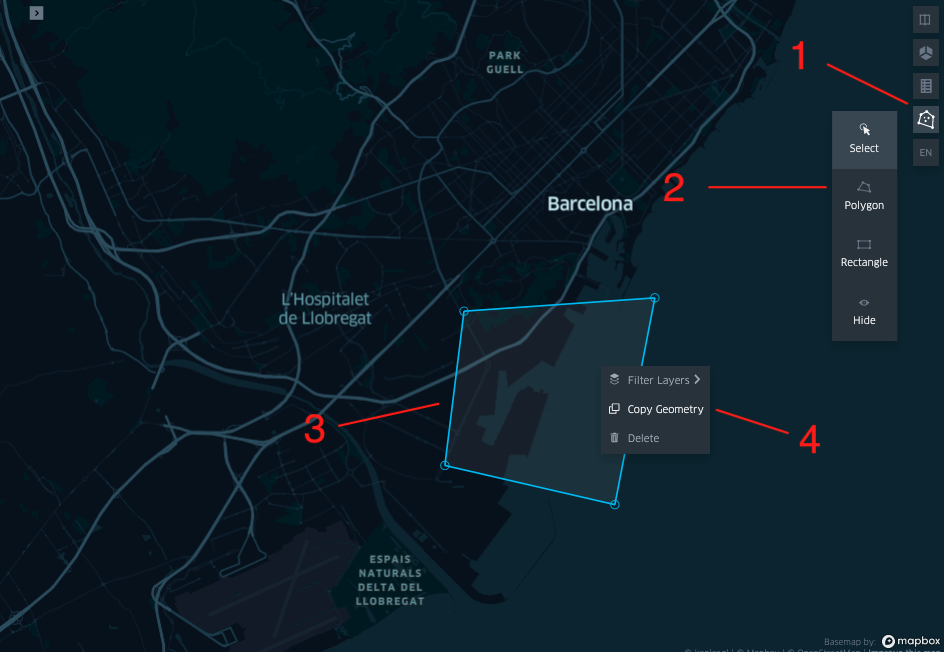

In [9]:
if KEPLER_OUTPUT:
    map_0 = KeplerGl(height=800)
    display(map_0)
else:
    display(Image("images/map0.png"))

In an interactive session the cell above produces creates an empty map where to draw a polygon and copy paste it in the cell below. In the static blog version this is not reproduced, as the variable `KEPLER_OUTPUT` is set to `False`.

You can get at the source notebook used to create this blog post and create a different polygon, using the drawing pencil (top right), then right click on it to copy the values and paste it in a dictionary.

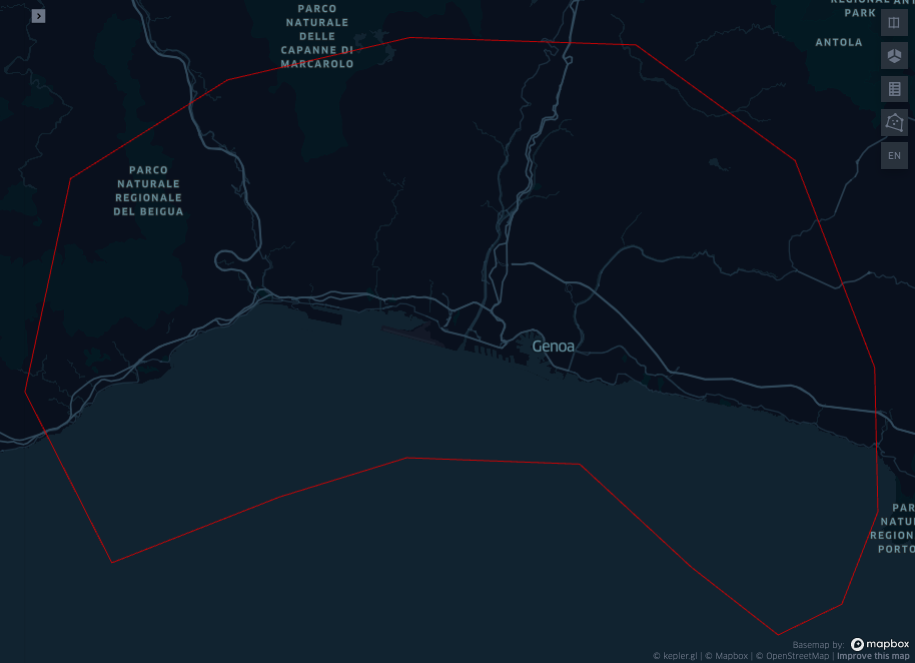

In [10]:
dict_roi = {"type":"Polygon","coordinates":[[[8.987382009236233,44.54680601507832],[8.841126105836173,44.550231465826634],[8.723022747221052,44.53065474626796],[8.621398927017932,44.48511343018655],[8.591873087363503,44.3865638718846],[8.64817817693631,44.307506289856086],[8.75666847147733,44.33796344890003],[8.83906616353428,44.35613196160054],[8.950989695244745,44.3531860988552],[9.023087675794352,44.30554076888227],[9.079392765366244,44.274083482671955],[9.120591611394707,44.288339652995674],[9.143937624144632,44.33108740800724],[9.141877681842741,44.39784910785984],[9.090379124307875,44.49344084451141],[8.987382009236233,44.54680601507832]]]}

sh_roi = shape(dict_roi)

config_map1 = {
    'version': 'v1',
    'config': {
        'mapState': {
            "bearing": 0,
            "dragRotate": False,
            "latitude": 44.41404004333898,
            "longitude": 8.871549089955757,
            "pitch": 0,
            "zoom": 10.347869665266995,
            "isSplit": False,
        }
    }
}

gdf_roi =  gpd.GeoDataFrame({"name":["ROI"], "geometry": [sh_roi]})
gdf_roi = gdf_roi.set_crs('4326')  # reproject to WGS84 (the only one supported by kepler)

# To reproduce exactly the same images shown in the article you will have to copy the config
# file from the linked repo and save it in the save it in a configs.py file.
# You can still follow the tutorial and run all the lines of code without the config.
try:
    from configs import config_map1
except ImportError:
    config_map1 = dict()
    
if KEPLER_OUTPUT:
    map_1 = KeplerGl(data=deepcopy({"roi": gdf_roi}), config=config_map1, height=800)
    display(map_1)
else:
    display(Image("images/map1.png"))


The copy pasted geometry from the kepler app is a dictionary with a type and a list of coordinates following a conventional GeoJSON object. GeoJSON is a format for encoding data about geographic features using JavaScript Object Notation (json), established in 2015.

A [geojson](https://geojson.org/) to model a single point appears as:

```json
{
  "type": "Feature",
  "geometry": {
    "type": "Point",
    "coordinates": [125.6, 10.1]
  },
  "properties": {
    "name": "Dinagat Islands"
  }
}
```

Where `"type"` can be `Feature` for single objects, or `FeatureCollections` for multiple objects, and where the `geometry.type` can be a `Point`, `LineString`, `Polygon`, `MultiPoint`, `MultiLineString`, and `MultiPolygon`.



To get the "water" within the selected geometry, we will use the `osmnx` library.

There are a few options to obtain land and water intersecting a region. It is possible to get the rivers, the sea (or bay), and the administrative regions and then consider to subtract the rivers to the administrative regions, and their intersection with the selected ROI. This option may leave some empty spaces, as in OSM there may be multiple annotators and the boundaries may not collimate.
A different approach is to assume that all what is not water is land. So we query the rivers and the sea, we consider their union and their intersection with the ROI, and we call this new region "water". The land will be the set difference between water and the ROI.

$$
\text{water}_{\text{roi}} = (\text{sea} \cup \text{river}) \cap \text{roi}\\
\text{land}_{\text{roi}} = \text{roi} \setminus \text{water}_{\text{roi}}
$$

So we need to perform the binary polygon operations of union, intersection and subtraction of polygons, as well as to get the polygons of sea and rivers involved in the selected roi.


In [16]:
# how to get tags:
# https://wiki.openstreetmap.org/wiki/Map_features#Water_related

# ~5 mins the first run (2 seconds after the first run, as results are stored in the local folder `cache`).
gdf_rivers = osmnx.geometries_from_polygon(sh_roi, tags={'natural': 'water'})
gdf_sea = osmnx.geometries_from_polygon(sh_roi, tags={'natural': 'bay'})

# check crs is already set to WGS84
assert gdf_rivers.crs == 4326
assert gdf_sea.crs == 4326

# Dissolve the "geodataframe" so that all of its rows are conflated into a single observation
gdf_rivers = gdf_rivers.dissolve()
gdf_sea = gdf_sea.dissolve()

# Compute water_roi and land_roi
gse_sea_union_river = gdf_rivers.union(gdf_sea)  # The union of two geodataframes is a geoseries (the union is only on the geometries)

gse_water_roi = gse_sea_union_river.intersection(gdf_roi)
gse_land_roi = gdf_roi.difference(gse_water_roi)

you can also explore the administrative boundaries for an alternative route to find the polygons segmenting land.
```
gdf_region = ox.geometries_from_polygon(sh_poly, tags={'boundary': 'administrative'})
```
But this route is not explored here, you are invited to investigate and plot it.

In [12]:
# Call deepcopy when passing an object prevents issue "AttributeError: 'str' object has no attribute '_geom'".
# https://github.com/keplergl/kepler.gl/issues/1240

gdf_genova = gpd.GeoDataFrame(
    {
        "name": ["roi", "water", "land"], 
        "geometry":[deepcopy(gdf_roi.geometry.iloc[0]), deepcopy(gse_water_roi.iloc[0]), deepcopy(gse_land_roi.iloc[0])]
    }
)

gdf_genova = gdf_genova.set_crs('4326')

display(gdf_genova.head())

,name,geometry
0,roi,"POLYGON ((8.98738 44.54681, 8.84113 44.55023, ..."
1,water,"MULTIPOLYGON (((8.62514 44.37508, 8.62505 44.3..."
2,land,"MULTIPOLYGON (((8.98738 44.54681, 9.04759 44.5..."


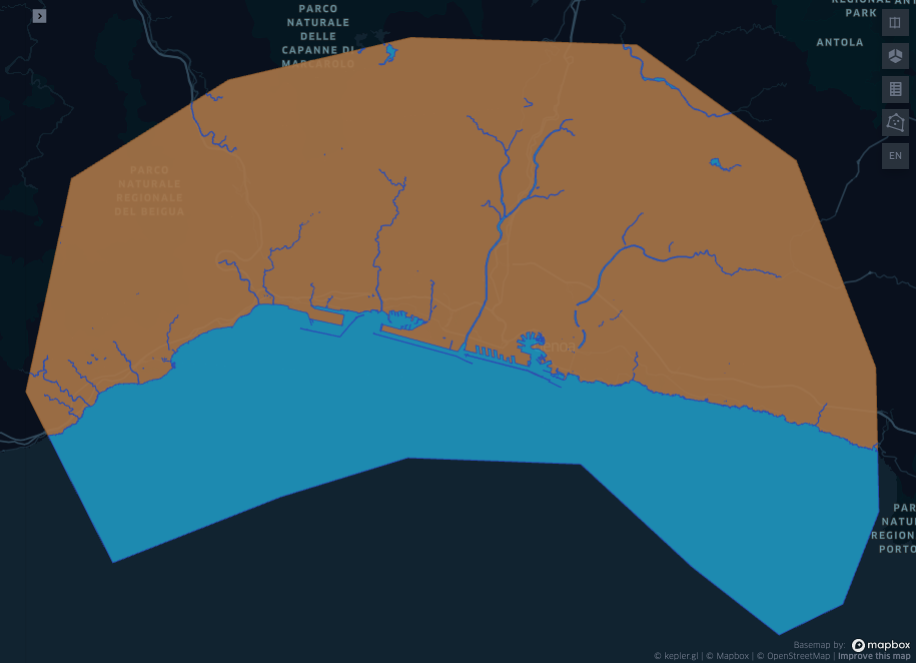

In [17]:
kepler_data = {}
for _, row in gdf_genova.iterrows():
    kepler_data.update({row["name"]: gdf_genova[gdf_genova["name"] == row["name"]].copy()})


try:
    from configs import config_map2
except ImportError:
    config_map2 = dict()


if KEPLER_OUTPUT:
    map_2 = KeplerGl(
        data=deepcopy(kepler_data), 
        height=800,
        config=config_map2,
    )
    display(map_2)
else:
    display(Image("images/map2.png"))


In [14]:
# Reproject to cylindrical equal area projectcion
gdf_genova["areas (Km2)"] = gdf_genova.to_crs({'proj':'cea'}).area/ 10**6
display(gdf_genova[["name", "areas (Km2)"]])

,name,areas (Km2)
0,roi,920.966148
1,water,330.635071
2,land,590.333976


## Polygons intersecting water and land... nearby!

There are situations when the manually delineated region may not be as accurate as it is required. It may be required to get some information of the areas "nearby" as well. "Nearby" can have different definitions, and here we get three of them:
1. Convex hull
2. Bounding Box
3. Buffer

The convex hull of the polygon $\Omega$ is the smallest convex polygon containing $\Omega$. The bounding box is the smallest rectangle containing $\Omega$ with edges parallel to the axis of the reference system. The buffer consists of enlarging the boundaries of $\Omega$ in a direction perpendicular to its sides. The analogous operation for raster objects is called *dilation* and it is one of the two most common morphological operations along with *erosion*.

But first we transform the operations we wrote so far into a function, taking `dict_roi` as input and returning the equivalent of `gdf_genova` for the selected area, which we can try for a different geometry. Then we test that the functions work for a different region. We chose the Viverone Lake, you are invited to select another one.

In [15]:
def water_and_land(roi: dict) -> gpd.GeoDataFrame:
    """from a polygon embedded in a geojson dict to a geodataframe with water, land and respective areas"""
    sh_roi = shape(roi)
    gdf_roi =  gpd.GeoDataFrame({"name":["ROI"], "geometry": [sh_roi]}).set_crs('4326')
    gdf_rivers = osmnx.geometries_from_polygon(sh_roi, tags={'natural': 'water'}).dissolve()
    gdf_sea = osmnx.geometries_from_polygon(sh_roi, tags={'natural': 'bay'}).dissolve()
    gse_sea_union_river = gdf_rivers.union(gdf_sea) if len(gdf_sea) else gdf_rivers
    gse_water_roi = gse_sea_union_river.intersection(gdf_roi)
    gse_land_roi = gdf_roi.difference(gse_water_roi)
    
    gdf = gpd.GeoDataFrame(
        {
            "name": ["roi", "water", "land"], 
            "geometry":[deepcopy(gdf_roi.geometry.iloc[0]), deepcopy(gse_water_roi.iloc[0]), deepcopy(gse_land_roi.iloc[0])]
        }
    ).set_crs('4326')
    
    gdf["areas (Km2)"] = gdf.to_crs({'proj':'cea'}).area/ 10**6
    
    return gdf


def split_gdf_to_layers(gdf: gpd.GeoDataFrame, column_name: str = "name") -> dict:
    kepler_data = {}
    for _, row in gdf.iterrows():
        kepler_data.update({row[column_name]: gdf[gdf[column_name] == row[column_name]].copy()})
        
    return kepler_data

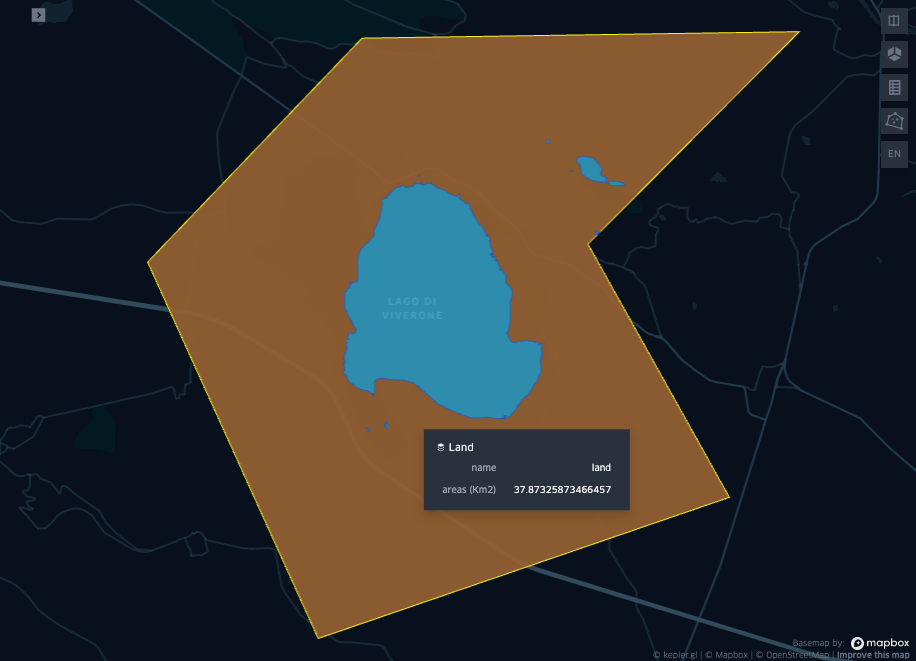

In [19]:
try:
    from configs import config_map3
except ImportError:
    config_map3 = dict()

if True:
    dict_viverone = {"type":"Polygon","coordinates":[[[8.098304589093475,45.44917237554611],[8.061826507846979,45.42337850571526],[8.086238762219843,45.3926467614535],[8.015246804101336,45.37550064157892],[7.985783738478874,45.42121207166915],[8.02282302097566,45.44838495097526],[8.098304589093475,45.44917237554611]]]}


if KEPLER_OUTPUT:
    # ~ 5 minutes first run - data are downloaded and cached
    map_3 = KeplerGl(
        data=deepcopy(split_gdf_to_layers(water_and_land(dict_viverone))), 
        height=800,
        config =config_map3,
    )
    display(map_3)
else:
    display(Image("images/map3.png"))


Now we can consider the three "nearby" operations. For simplicity all the three operations we are interested in are embedded in a class.

In [20]:

class GeoOperations:

    @staticmethod
    def _data_to_gdf(roi: dict) -> gpd.GeoDataFrame:
        """ input value `data` is a dumped geojson to a string format """
        sh_roi = shape(roi)
        return gpd.GeoDataFrame({"name":["ROI"], "geometry": [sh_roi]}).set_crs(4326)
    
    @staticmethod
    def _add_area_column(gdf: gpd.GeoDataFrame) -> None:
        gdf["areas (Km2)"] = gdf.to_crs({'proj':'cea'}).area/ 10**6
        
    @staticmethod
    def _get_polygon_box(row):
        c_hull = row.convex_hull  # make sure the input is a polygon 
        x, y, X, Y = c_hull.bounds
        return shapely.geometry.Polygon([(x, y), (X, y), (X, Y), (x, Y), (x, y)])
    
    def buffer(self, data: str, buffer_meters:float = 10) -> gpd.GeoDataFrame:
        gdf = self._data_to_gdf(data)
        gdf.geometry = gdf.to_crs(crs=3857)['geometry'].buffer(buffer_meters).to_crs(4326)
        self._add_area_column(gdf)
        return gdf

    def convex_hull(self, data: str) -> gpd.GeoDataFrame:
        gdf = self._data_to_gdf(data)
        gdf.geometry = gdf['geometry'].convex_hull
        self._add_area_column(gdf)
        return gdf
        
    def bbox(self, data: str) -> gpd.GeoDataFrame:
        gdf = self._data_to_gdf(data)
        gdf['geometry'] = gdf['geometry'].apply(lambda x: self._get_polygon_box(x))
        self._add_area_column(gdf)
        return gdf


In [23]:
kepler_data = split_gdf_to_layers(water_and_land(dict_roi))

ge_ops = GeoOperations()
kepler_data.update({"buffer": ge_ops.buffer(dict_roi, 5_000), "convex hull": ge_ops.convex_hull(dict_roi), "bbox": ge_ops.bbox(dict_roi)})

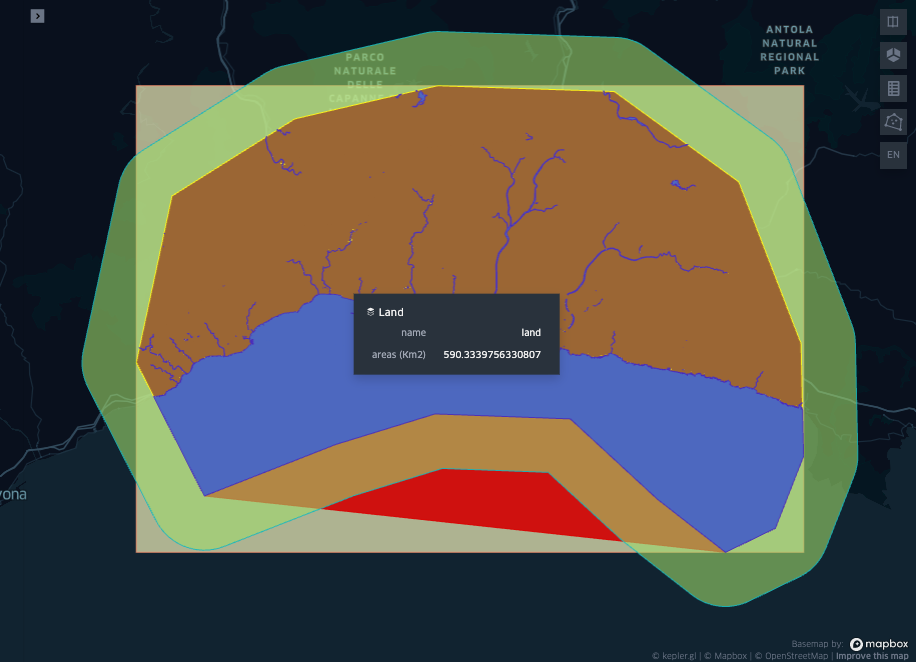

In [24]:
try:
    from configs import config_map4
except ImportError:
    config_map4 = dict()


if KEPLER_OUTPUT:
    map_4 = KeplerGl(
        data=deepcopy(kepler_data),
        height=800,
        config=deepcopy(config_map4),
    )
    map_4
else:
    display(Image("images/map4.png"))


In the picture above the bounding box, buffer and convex hull were added to the selected geometry, but the land and sea was not computed for these new polygons. This is left for the reader for practice. For example the water and land within the bounding box should look like the figure below:

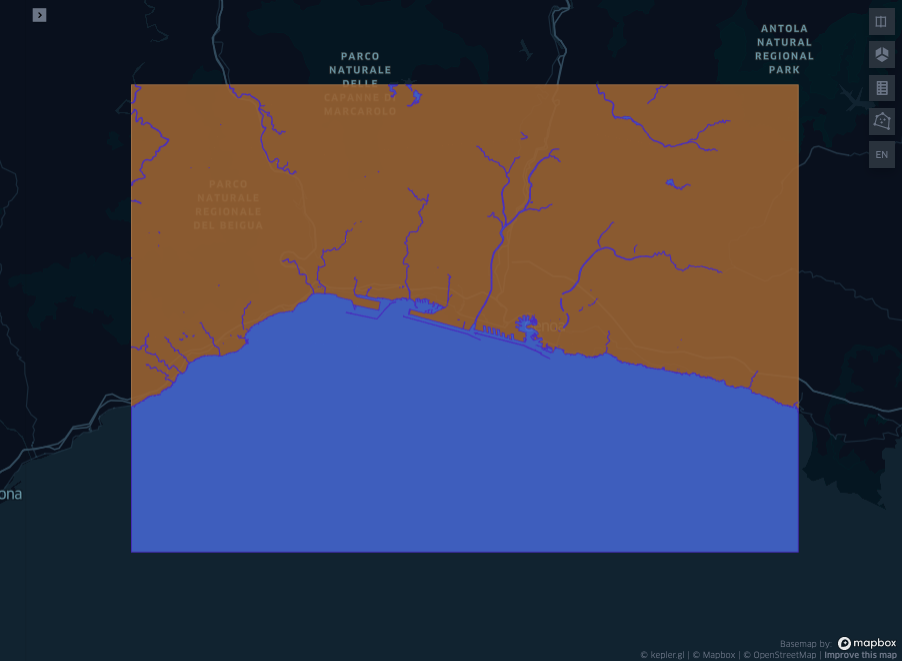

In [25]:
dict_bbox = ge_ops.bbox(dict_roi)["geometry"].iloc[0].__geo_interface__

if KEPLER_OUTPUT:
    map_5 = KeplerGl(
        data=split_gdf_to_layers(water_and_land(dict_bbox)), 
        height=800,
        config=deepcopy(config_map4), # we can re-use the same config as the previous map
    )
    map_5
else:
    display(Image("images/map5.png"))


1.3 Which country intersects this polygon?

Imagine now to draw a polygon on the map with the goal of solving the following problem:

> Get the list with the names of all the countries intersecting the given polygon.

There are two options we can see think of to solve this problem with `osmnx`:
1. Create a GeoDataFrame in memory with all the countries in the world, and then compute the intersection between the dataframe and the given polygon.
2. Feed the given polygon to osmnx directly, and use the right tag to get all the countries intersecting it.

The first one is very slow to initialise, though fast each time a new polygon is passed to the `intersect` method. The second one is relatively slow each time a new polygon is given.

Here, out of laziness we will not use any of the methods above. The toy dataset provided `geopandas` contains already all the information that we need, so we will use this one instead of the one provided by osmnx.

As usual the first step is to draw a polygon on the first empty map of the notebook. Then copy paste the polygon geojson below, to be saved in the variable `dict_roi`. We selected a rectangular region around Myanmar, the reader is free to act according to preference.

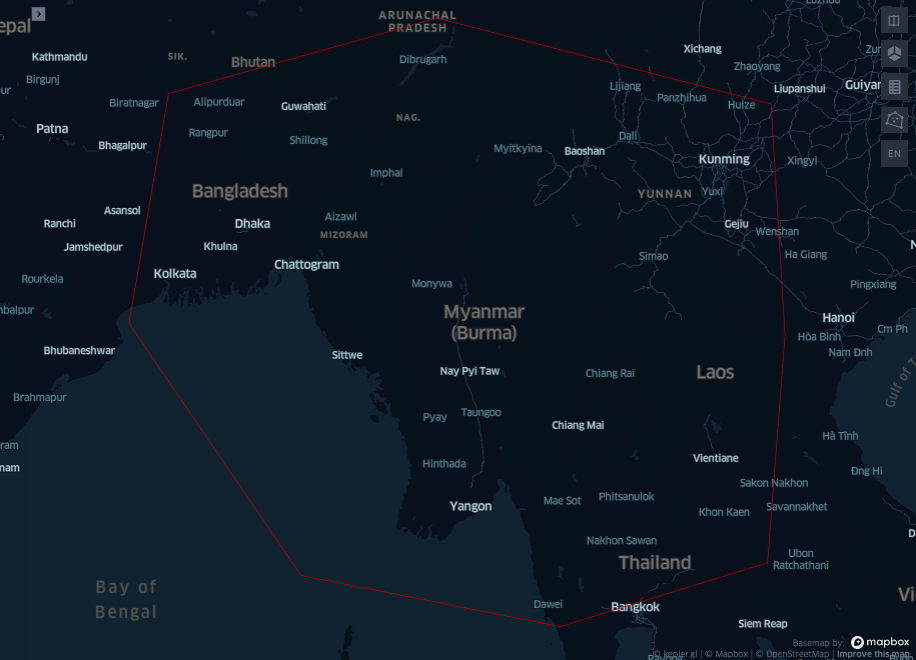

In [26]:
dict_roi = {"type":"Polygon","coordinates":[[[95.27405518168942,28.464895473156595],[88.19328456832459,26.69900877882346],[87.15109322263424,21.154320639876016],[91.6876908450501,14.831845554981104],[98.52323996531177,13.52423467533735],[103.97941818686449,15.157545455928199],[104.43920848643478,20.868173454079436],[104.0713762467781,26.45228108415989],[95.27405518168942,28.464895473156595]]]}

sh_roi = shape(dict_roi)

gdf_roi =  gpd.GeoDataFrame({"name":["ROI"], "geometry": [sh_roi]})
gdf_roi = gdf_roi.set_crs('4326')

try:
    from configs import config_map6
except ImportError:
    config_map6 = dict()

if KEPLER_OUTPUT:
    map_6 = KeplerGl(data=deepcopy({"roi": gdf_roi}), height=800, config=config_map6)
    display(map_6)
else:
    display(Image("images/map6.png"))


(-198.0, 198.00000000000006, -98.6822565, 92.3273865)

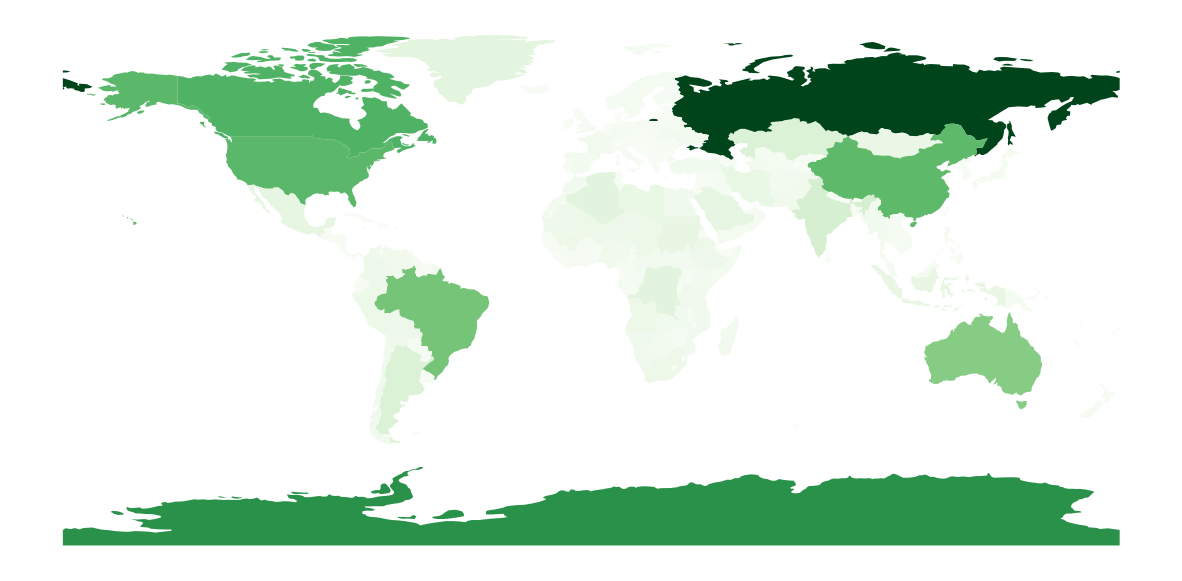

In [32]:
import geopandas as gpd

gdf_countries = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf_countries["areas (Km2)"] = gdf_countries.to_crs({'proj':'cea'}).area/ 10**6

ax = gdf_countries.plot(figsize=(15, 15), column='areas (Km2)', cmap='Greens')
ax.axis('off')  # images/map_naturalearth.png


In [34]:
dict_roi = {"type":"Polygon","coordinates":[[[95.27405518168942,28.464895473156595],[88.19328456832459,26.69900877882346],[87.15109322263424,21.154320639876016],[91.6876908450501,14.831845554981104],[98.52323996531177,13.52423467533735],[103.97941818686449,15.157545455928199],[104.43920848643478,20.868173454079436],[104.0713762467781,26.45228108415989],[95.27405518168942,28.464895473156595]]]}

sh_roi = shape(dict_roi)

# note gdf_countries.intersects(sh_roi) returns a boolean series.

gdf_intersection_countries = gdf_countries[gdf_countries.intersects(sh_roi)].reset_index(drop=True)
gdf_intersection_countries[["name", 'areas (Km2)']].head(10)

display(gdf_intersection_countries.head())

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,areas (Km2)
0,68414135,Asia,Thailand,THA,1161000.0,"POLYGON ((105.21878 14.27321, 104.28142 14.416...",5.101229e+05
1,7126706,Asia,Laos,LAO,40960.0,"POLYGON ((107.38273 14.20244, 106.49637 14.570...",2.290354e+05
2,55123814,Asia,Myanmar,MMR,311100.0,"POLYGON ((100.11599 20.41785, 99.54331 20.1866...",6.795988e+05
3,96160163,Asia,Vietnam,VNM,594900.0,"POLYGON ((104.33433 10.48654, 105.19991 10.889...",3.360194e+05
4,1281935911,Asia,India,IND,8721000.0,"POLYGON ((97.32711 28.26158, 97.40256 27.88254...",3.142772e+06


Left to the reader is to add a column with the information of the the percentage of the area covered by the selected roi over each country (e.g. Myanmar will be 100% covered by the ROI. What about China?).

## Distances between countries

Now let's say you have two polygons representing two countries. How to compute their distance in Km on the surface of the earth?

In [36]:
list_countries = sorted(list(gdf_countries.name))
list_countries[:10]

['Afghanistan',
 'Albania',
 'Algeria',
 'Angola',
 'Antarctica',
 'Argentina',
 'Armenia',
 'Australia',
 'Austria',
 'Azerbaijan']

In [38]:
gdf_countries.to_crs(epsg=27700,inplace=True) # more about 27700 on the next article! The impatient reader can look under https://epsg.io/27700

sh_france = gdf_countries[gdf_countries.name == "France"].geometry.iloc[0]
sh_italy = gdf_countries[gdf_countries.name == 'Italy'].geometry.iloc[0]
sh_uk = gdf_countries[gdf_countries.name == 'United Kingdom'].geometry.iloc[0]

print(f"Distance between France and UK polygons: {round(sh_france.distance(sh_uk) / 1_000, 3)} Km")

Distance between France and UK polygons: 37.14 Km


A quick investigation using google seems to not confirm this number. Google says the distance is approx 32Km. Did we do something wrong? Let's use google maps and pick the two point that are visually the closest to each others on the coasts, copy paste them to the notebook and see what is their distance:

In [40]:
a = (51.108648, 1.286524)
b = (50.869575, 1.583608)

print(f"Distance between France and UK by naked eye: {round(distance.distance(a, b).km, 3)} Km")

Distance between France and UK by naked eye: 33.801 Km


This number looks way closer to the one found with the shapely `distance` method. So Why the discrepancy? Is it a problem with the coordinates? Maybe the `27700` is not the optimal one in this case?

Looking at the data we can find that the accuracy of the countries segmentation is way less that the actual underlying coast. The accuracy is so low that the distance between the polygon is actually wider!

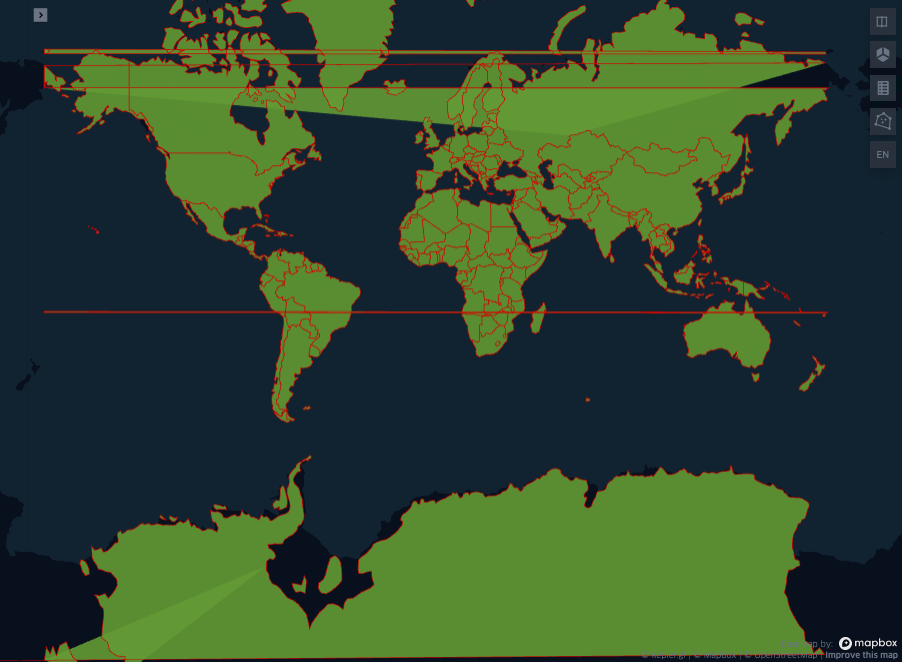

In [41]:
try:
    from configs import config_map7
except ImportError:
    config_map7 = dict()

if KEPLER_OUTPUT:
    map_7 = KeplerGl(data=deepcopy({"rois": gdf_countries.to_crs('4326')}), height=800, config=config_map7)
    display(map_7)
else:
    display(Image("images/map7.png"))


NOTE: the artefacts that you can see in the map above are caused by polygons crossing the antimeridian. This topic will be discussed in the next blog post of the polygon series "reference systems for polygons".

This section also confirmed numerically the importance of the quality of the segmentation in taking measurements, which lead us straight to the next (and last!) section of this first tutorial about polygons.

## Same country, different borders: how different are they?

The problem we want to address in this section is to quantify the differences between segmentations of the same region. As often happens in geospatial data science (and not only there) a ground truth is not available. Also, as in the case of natural phenomena, the true segmentation varies over time, and an approximation is all what we can get. Quantifying the differences between two shapes consists of reducing the dimensionality of the problem, from 2D to 1D. The methods here presented can be generalised from ND to 1D, which can happen in case altitude and time are taken into account in the segmentation process.

We will take three segmentations of a the Laguna Honda reservoir in San Francisco, CA: a most accurate, a less accurate, and an absurdly inaccurate one, then we measure their distances with a range of four metrics. 

In [42]:
dict_lh_accurate = {"type":"Polygon","coordinates":[[[-122.46336870734235,37.75382312075932],[-122.46361657885608,37.75373534452417],[-122.4635831171001,37.75365833165909],[-122.46316396885612,37.75301643279386],[-122.46300520664897,37.752840487963525],[-122.46230161881246,37.7522463019286],[-122.46211503445602,37.75203693263166],[-122.46178081988387,37.75186782984793],[-122.46148855443528,37.75184019740165],[-122.46133288449474,37.75201341062547],[-122.4612061599761,37.752084737992796],[-122.46103218224685,37.75214417741294],[-122.46077014171657,37.752179841041794],[-122.46037947391036,37.752188392148845],[-122.46021718629451,37.75217343769624],[-122.4600201930734,37.75211950941181],[-122.45991172291727,37.75207281219638],[-122.45983991818758,37.752077610017345],[-122.45994274713122,37.75230912513596],[-122.45996851594319,37.75240437677724],[-122.46006708164848,37.7524522572354],[-122.46084756619754,37.752511150412346],[-122.46122218790283,37.75259302382214],[-122.46131143485962,37.75262966326064],[-122.46167022567394,37.7526676568636],[-122.46188775902073,37.75272257149743],[-122.46205025380969,37.752816858793715],[-122.462376261119,37.75308710607375],[-122.46251137863547,37.753166819591506],[-122.46262051201403,37.75320708721178],[-122.46268905680037,37.75326534110075],[-122.46270650192626,37.75330849493771],[-122.46273109980764,37.753422092415555],[-122.46277517530947,37.75345753879545],[-122.4628296309809,37.7534771096768],[-122.46294915057157,37.75346704465253],[-122.4630682867433,37.753516920096686],[-122.46336870734235,37.75382312075932]]]}

dict_lh_less_accurate = {"type":"Polygon","coordinates":[[[-122.46336953589098,37.753832862738975],[-122.4636233738959,37.75373251334907],[-122.4631072366194,37.75293640336153],[-122.46177458709447,37.75186264481159],[-122.46148267338904,37.75183922934248],[-122.4612246047509,37.752080073813296],[-122.46047155200345,37.75218711554916],[-122.4599004164929,37.752066693585995],[-122.45984118762517,37.752080073813296],[-122.45996387599406,37.752411233681165],[-122.46131767868594,37.752618625974755],[-122.46194804306447,37.75272232190355],[-122.46268840391157,37.75324748937671],[-122.46272647961233,37.753431464361086],[-122.46314954295359,37.75359536896148],[-122.46336953589098,37.753832862738975]]]}


dict_lh_inaccurate = {"type":"Polygon","coordinates":[[[-122.46176576455443,37.75368924488866],[-122.46242948841775,37.75334575268072],[-122.4631052799878,37.752296183276115],[-122.46372073302484,37.75144697531703],[-122.46259843631039,37.75127522420765],[-122.46204332180642,37.75167597617579],[-122.46192264474033,37.752410682480374],[-122.46095722821178,37.752954551279636],[-122.4605348584804,37.75364153773237],[-122.46176576455443,37.75368924488866]]]}


sh_lh_accurate = shape(dict_lh_accurate)
sh_lh_less_accurate = shape(dict_lh_less_accurate)
sh_lh_inaccurate = shape(dict_lh_inaccurate)

gdf_lh_accurate = gpd.GeoDataFrame({"name":["Accurate"], "geometry": [sh_lh_accurate]}).set_crs('4326')
gdf_lh_less_accurate = gpd.GeoDataFrame({"name":["Less accurate"], "geometry": [sh_lh_less_accurate]}).set_crs('4326')
gdf_lh_inaccurate = gpd.GeoDataFrame({"name":["Inaccurate"], "geometry": [sh_lh_inaccurate]}).set_crs('4326')


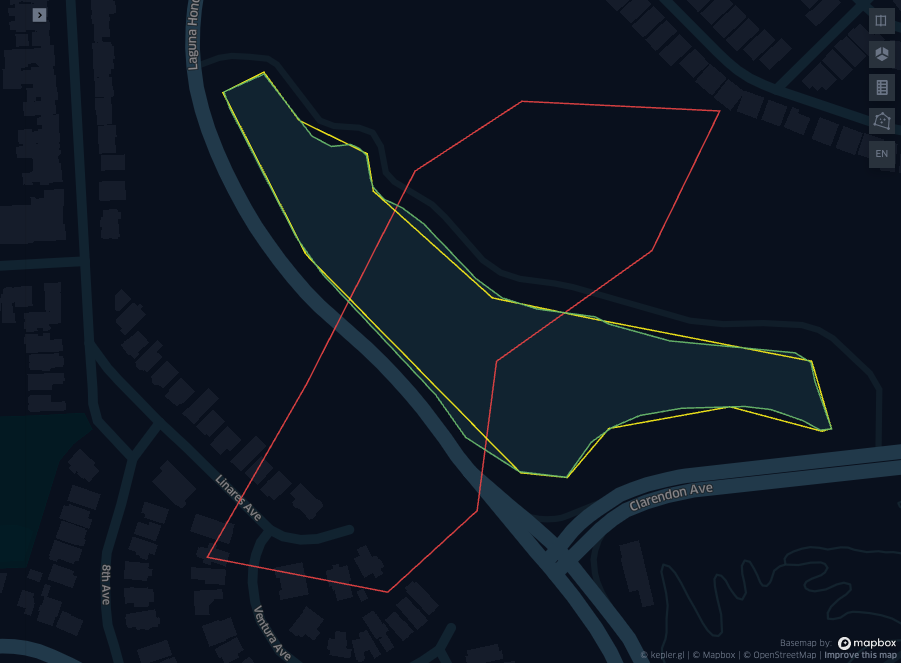

In [43]:
try:
    from configs import config_map8
except ImportError:
    config_map8 = dict()

if KEPLER_OUTPUT:
    map_8 = KeplerGl(
        data={
            "Laguna Honda accurate": deepcopy(gdf_lh_accurate),
            "Laguna Honda less accurate": deepcopy(gdf_lh_less_accurate),
            "Laguna Honda inaccurate": deepcopy(gdf_lh_inaccurate),
        }, 
        height=800,
        config=config_map8
    )
    display(map_8)
else:
    display(Image("images/map8.png"))


### Dice's Score
After Lee R. Dice, the Dice's score measures the area of the overlap between two polygons normalised to the sum of the individual areas of the two polygons. Therefore if the polygon are perfectly congruent, then the dice equals 1, if there is no intersection between the two elements, the measure is zero.

Formally: let $P_1$ and $P_2$ be two simple (i.e. where their area can be computed uniquely) polygons drawn on a map, $\mathcal{A}(P_1)$ and $\mathcal{A}(P_2)$ their area, and $P_1 \cap P_2$ their intersection. The Dice's score of $P_1$ and $P_2$ is defined as:
$$
\text{Dice}(P_1, P_2) = \frac{2 \mathcal{A}(P_1 \cap P_2) }{ \mathcal{A}(P_1) + \mathcal{A}(P_2)}~.
$$

This definition does not correspond to the intuitive definition of a distance that is zero when the measured object as as close to each others as possible.

### Dice's Distance

The Dice's score can be turned into a distance simply modifying its formula as:
$$
\text{DiceDist}(P_1, P_2) = 1 - \frac{2 \mathcal{A}(P_1 \cap P_2) }{ \mathcal{A}(P_1) + \mathcal{A}(P_2)}~,
$$
so that the distance between two identical polygons is zero.

### Covariance Distance

We can consider the polygon's vertex as a cloud of points, and compare the principal components of their distribution encoded as a Symmetric Positive Definite matrix through the covariance matrix. 

The covariance distance is given by the sum of the 2 eigenvalues of the product of the covariance matrices, normalised by the sum of the products of squared eigenvalues of each covariance matrix. As done for the dice score, to have zero when the two shapes are identica, we take $1$ minus the value obtained.

Formally: with the same notation as above the covariance distance is defined as
$$
\text{CovDist}(P_1, P_2) = \alpha \left( 1 - \frac{ \text{Tr}( \text{c}(P_1) \text{c}(P_2) )  }{ \text{Fro}(P_1) + \text{Fro}(P_2)} \right) ~,
$$
where $\alpha$ is a multiplicative factor to scale the data (it can be one if the points are normalised with standard deviation = 1, or computed as the reciprocal of the average standard deviations of the clouds distributions), and $\text{Tr}$ and $\text{Fro}$ are the trace and Frobenius norm respectively.


### Hausdoroff Distance

The main feature of the covariance distance is that only the principal components of the two geometries are considered, and the noise is not taken into account. The Hausdoroff distance instead aims at being very sensitive to the misplacement of a single vertex between the two geometries.

It's definition is based on as maximal distance between the vertex of one polygon  the distance between the
$$
\text{HausDist}(P_1, P_2) = \text{max} \left\{ \text{max}_{p_i \in \partial P_1} d(p_i, \partial P_2) , \text{max}_{p_j \in \partial P_2} d(p_j, \partial P_1) \right\} ~,
$$
where $\partial P_1$ is the contour, or perimeter of the polygon $P_i$ and $d$ is the Euclidean distance (or in the case of the curved surface, the geodesic distance).


### Normalised Symmetric Contour distance

The contour distance between $P_1$ and $P_2$ is given by the the sum of the distances of all the vertex of $P_1$ to the contour of $P_2$. 

As contour distance so defined is not symmetric (the contour distance between $P_1$ and $P_2$ is not the same of the contour distance between $P_2$ and $P_1$), we can make it symmetric considering the sum of the contour distance between $P_1$ and $P_2$ with the contour distance between $P_2$ and $P_1$. 

The distance can be normalised considering a distance factor encompassing both geometries in respect to their distances, which can be the lengths of both perimeters.

Formally:
$$
\text{NSCD}(P_1, P_2) = \frac{  S(P_1, P_2) + S(P_1, P_2) }{ \vert \partial P_1 \vert + \vert \partial P_2 \vert } ~,
$$
where the length of the contour is indicated with $\vert \partial P_i \vert$, and $S(P_1, P_2)$ is the contour distance, computed as:
$$
S(P_2, P_1) = \sum_{p_i \in \partial P_1} d(p_i, \partial P_2)~.
$$

Below we implement the four distances in a class and then we use this tool to measure the distances between the polygon we created above: `sh_lh_accurate`, `sh_lh_less_accurate` and `sh_lh_inaccurate`.

As usual you are invited to try it out on your own, on different geometries, to check the behaviours of the distances.


In [44]:
class Dist:
    def __init__(self, p1: Polygon, p2: Polygon):
        self.p1 = p1
        self.p2 = p2
        self.prec = 6
        
    def dice(self) -> float:
        assert self.p1.area + self.p2.area > 0, "Polygons must have positive areas."
        return np.round(1 - 2 * self.p1.intersection(self.p2).area / (self.p1.area + self.p2.area), self.prec)
    
    def cov(self) -> float:
        x1, y1 = self.p1.exterior.coords.xy[0], self.p1.exterior.coords.xy[1]
        x2, y2 = self.p2.exterior.coords.xy[0], self.p2.exterior.coords.xy[1]
        cov1 = np.cov(np.array([(x1 - np.mean(x1)) /  np.std(x1), (y1 - np.mean(y1)) / np.std(y1) ]))
        cov2 = np.cov(np.array([(x2 - np.mean(x2)) /  np.std(x2), (y2 - np.mean(y2)) / np.std(y2) ]))
        return np.round((1 - (np.trace(cov1.dot(cov2)) / (np.linalg.norm(cov1, ord='fro') * np.linalg.norm(cov2, ord='fro')))), self.prec)
    
    def hau(self) -> float:
        """ measured in degrees !!"""
        return np.round(self.p1.hausdorff_distance(self.p2), self.prec)
    
    def nsc(self) -> float:
        """ measured in degrees !!"""
        def bd(p1, p2):
            return np.round(sum([p1.boundary.distance(Point(x, y)) for x,y in zip(p2.exterior.coords.xy[0], p2.exterior.coords.xy[1])]), self.prec)
        
        return (bd(self.p1, self.p2) + bd(self.p2, self.p1)) / (self.p1.length + self.p2.length)
    
    def d(self, selected_measure: str) -> float:
        map_measures = {
            "dice": self.dice,
            "cov": self.cov,
            "haus": self.hau,
            "nsc": self.nsc,
        }
        return map_measures[selected_measure]()
        
        

In [47]:
# simplify the name according to the polygons colour in the image above
green = sh_lh_accurate
yellow = sh_lh_less_accurate
red = sh_lh_inaccurate

meas = [ "dice", "cov", "haus", "nsc"]

df_dist = pd.DataFrame(
    {
        "green - green": [Dist(green, green).d(m) for m in meas],
        "green - yellow": [Dist(green, yellow).d(m) for m in meas],
        "green - red": [Dist(green, red).d(m) for m in meas],
        "yellow - red": [Dist(yellow, red).d(m) for m in meas],    
    },
    index=meas
)  

display(df_dist)


,green - green,green - yellow,green - red,yellow - red
dice,-0.0,0.039633,0.760388,0.783997
cov,0.0,0.000104,0.692591,0.706379
haus,0.0,0.000078,0.001526,0.001545
nsc,0.0,0.044710,1.657110,1.038613


#### Note 1:

The considered Hausdorff and nsc distances are in degrees and not in meters. As we want to have a measure of the differences for geometries (specifically geometries within comparable latitude intervals) this is not invalidating the results. Though there are cases when these metrics should return the results in meters. This is left as an exercise for the reader (you can leave a comment below for a discussion about possible solutions!).

#### Note 2:

The same methods can be used for comparing the differences in shape of two objects that are expected to be similar or two measure the variability of two shapes that are changing over time, assuming that their segmentation is accurate and unbiased. 

Also the same method can be used to measure the accuracy of a segmentation of two different people segmenting the same object (inter-rater variability) or the same person segmenting twice the same object (intra-rater variability). If the variability is assessed without the rater knowing he is segmenting twice the same shape (out of a stack of different shapes to undergo segmentation, one is repeated twice, re-labelled and re-shuffled in the stack), then this experiment is called test re-test.

## Appendix: list of topics and further theoretical ideas

In solving three recurring problems we went through a relatively long list of topics. To maintain an hands on approach, the theory was barely touched.
In the list below you can find a summary reporting the list of the topics touched and some hints to dig further into the theory:

- Polygons and sets
    - polygon as a list of vectors
    - polygon as a set on a surface
    - operations between sets: union, intersection, difference, disjoint union.
    - Can you express union and difference as combinations of intersection and disjoint union?
    - De Morgan laws
    - Mathematical concept of Algebra and sigma algebra. Are the polygons on the surface of a sphere with the operation of intersection and disjoint union a sigma algebra?
    - Geojson format to represent a polygon
    - Geojson to shapely, and shapely operations
    - Adding metadata to a polygon with geopandas
    - Osmnx library
    - Visualisation with KeplerGl and WGS84 


- Morphological operations in GIS
    - Dilation (or buffer) and erosion
    - Bounding box
    - Convex hull
    - Class as a toolbox


- Distance between polygons and projections
    - "Optimal Algorithms for Computing the Minimum Distance Between Two Finite Planar Sets" Toussaint, Bhattacharya
    - Minkovsky sum
    - Haversine distance
    - Vincentry distance


- Shape differences
    - Segmentation
    - Difference quantification as a dimensionality reduction problem
    - Intra-rater and inter-rater variability
    - Dice's score
    - Covariance of a polygon (of a set of 2d points) and covariance distance
    - Hausdoroff distance
    - Normalized symmetric contour distance


## Resources

- Geopandas and shapely basics [https://www.learndatasci.com/tutorials/geospatial-data-python-geopandas-shapely/](https://www.learndatasci.com/tutorials/geospatial-data-python-geopandas-shapely/)
- Shapely manual [https://shapely.readthedocs.io/en/stable/manual.html](https://shapely.readthedocs.io/en/stable/manual.html)
- Geopandas crs usage [https://geopandas.org/en/stable/docs/user_guide/projections.html](https://geopandas.org/en/stable/docs/user_guide/projections.html)
- intersection polygon algorithm [https://www.swtestacademy.com/intersection-convex-polygons-algorithm/](https://www.swtestacademy.com/intersection-convex-polygons-algorithm/)
- Buffer (dilation) to remove holes [https://gis.stackexchange.com/questions/409340/removing-small-holes-from-the-polygon/409398](https://gis.stackexchange.com/questions/409340/removing-small-holes-from-the-polygon/409398)
- maps projections [https://automating-gis-processes.github.io/2017/lessons/L2/projections.html](https://automating-gis-processes.github.io/2017/lessons/L2/projections.html)
- Trace and covariance [https://online.stat.psu.edu/stat505/lesson/1/1.5](https://online.stat.psu.edu/stat505/lesson/1/1.5)

## Inspired by

- [Qiusheng Wu](https://github.com/giswqs)
- [Maxime Labonne](https://mlabonne.github.io/blog/)


